# **Implementing Retrieval-Augmented Generation (RAG) on Medical Wiki Terms Dataset**



## **1. Project Overview**

- **Objective**: Build a RAG architecture for answering medical-related questions based on the `gamino/wiki_medical_terms` dataset.

- **Dataset**: Medical Wiki Terms dataset containing medical terms, definitions and more.
  

- **Key Components**:

  1. Data preprocessing

  2. Document embedding and storage

  3. Retrieval system setup

  4. Language model integration for response generation

  5. Evaluation of the RAG pipeline

---

## **2. Setup and Data Loading**

### **2.1. Install Required Libraries**

- Install the necessary libraries:

  - LangChain

  - Hugging Face Datasets

  - Pinecone vectore store

  - OpenAI or Hugging Face Transformers for language models

In [1]:
!pip install -q langchain==0.3.8
!pip install -q langchain-community==0.3.8
!pip install -q langchain-huggingface==0.1.2
!pip install -q langchain-pinecone==0.2.0

!pip install -q transformers==4.47.0
!pip install -q datasets==3.1.0

!pip install -q pinecone-client==5.0.1

!pip install -q pyngrok==7.2.1
!pip install -q streamlit==1.40.1

# !pip install -q nltk==3.9.1
!pip install -q rouge-score==0.1.2
!pip install -q bert-score==0.3.13

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.2 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which 

In [2]:
import numpy as np
import pandas as pd
import json
from datasets import load_dataset


#

### **2.2. Load the Dataset**

- Load the `gamino/wiki_medical_terms` dataset using the Hugging Face Datasets library.

- Explore the dataset to understand its structure (fields like `page_title` and `page_text`).


In [ ]:
dataset_raw = load_dataset("gamino/wiki_medical_terms")

In [ ]:
dataset_raw['train']

---


## **3. Preprocessing**


### **3.1. Data Cleaning**

- Remove unnecessary fields or rows if any.

- Ensure consistent formatting for terms and definitions.

In [ ]:
pages = [doc for doc in dataset_raw['train']['page_text']]
metadata = [title for title in dataset_raw['train']['page_title']]



# Ensure pages and metadata have the same length
assert len(pages) == len(metadata), "Mismatch between pages and metadata lengths!"
assert dataset_raw['train'].filter(lambda x: any(v is None for v in x.values())).num_rows == 0, "Dataset contains null values!"


### **3.2. Convert to LangChain Documents**

- Combine the medical terms and their definitions into LangChain `Document` objects.

- Metadata should include the `page_title` for easy traceability.

In [ ]:
from langchain.schema import Document

# Create a list of Document objects
input_documents = [
    Document(page_content=page, metadata={"title": title})
    for page, title in zip(pages, metadata)
]

### 3.3 Chunking the `page_title` due to its long context

- Consider Recursive Chunking to preserve context for retrieval

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_documents(input_documents, chunk_size=1000, chunk_overlap=100):
    """
    Splits a list of Document objects into smaller chunks while preserving metadata.

    Parameters:
        input_documents (list of Document): List of Document objects to be split.
        chunk_size (int): Maximum size of each chunk in characters.
        chunk_overlap (int): Number of overlapping characters between chunks.

    Returns:
        list of Document: A list of new Document objects with split content.
    """

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    output_documents = []

    for doc in input_documents:
        
        # Split the content of each document
        chunks = text_splitter.split_text(doc.page_content)

        # Create new Document objects for each chunk while preserving metadata
        for chunk in chunks:
            output_documents.append(Document(page_content=chunk, metadata=doc.metadata))

    return output_documents


In [ ]:
chunked_docs = split_documents(input_documents=input_documents)

In [ ]:
print(f"Number of chunks: {len(chunked_docs)}")
print(f"Average length (no. of words) of chunks: {sum(len(doc.page_content.split()) for doc in chunked_docs) / len(chunked_docs):.2f} words")
print(f"Average length (no. of characters) of chunks: {sum(len(doc.page_content) for doc in chunked_docs) / len(chunked_docs):.2f} characters")

In [ ]:
# counter = 0

# for doc in chunked_docs:

#   if len(doc.page_content.split()) < 11:
#     print(doc.page_content)
#     print(f"Metadata:{doc.metadata}")
#     print("*"*100)
#     counter += 1

# print(f"Number of documents with length less than 11 words: {counter}")   ## Here we see that these chunks are meaningless so we can drop them

**Note**: Here we have `12599` chunks less than 11 words, which are meaningless and we can drop

In [ ]:
# Drop Chunks less than 11
chunked_docs = [doc for doc in chunked_docs if len(doc.page_content.split()) >= 11]

In [ ]:
print(f"Number of new chunks: {len(chunked_docs)}")
print(f"Average length (no. of words) of new chunks: {sum(len(doc.page_content.split()) for doc in chunked_docs) / len(chunked_docs):.2f} words")
print(f"Average length (no. of characters) of new chunks: {sum(len(doc.page_content) for doc in chunked_docs) / len(chunked_docs):.2f} characters")

In [ ]:
print(f"Max Chunk size in words: {max(len(doc.page_content.split()) for doc in chunked_docs)}")
print(f"Min Chunk size in words: {min(len(doc.page_content.split()) for doc in chunked_docs)}")

**Note:** It is crucial to ensure that the maximum chunk size is less than or equal to the context length of the embedding model you are using. In this case, the maximum chunk size in words is **201**, which is less than the context length of the **all-MiniLM-L6-v2** model, which is **256**. This is in accordance with the [model documentation on Hugging Face](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).


In [ ]:
chunked_docs[0].page_content

In [ ]:
chunked_docs[1].page_content

---

### 3.4 Summarize each `page_text` using an LLM

- This approach will increase the accuracy of retrieval based on experienced trial and error. (still under test)

#### Why Summarization and Why After Chunking?

- **Why Summarization?**  
  Summarization helps us focus on the key points of a document without getting lost in unnecessary details. It saves time and makes it easier to work with long texts by distilling them into their most important ideas.

- **Why After Chunking?**  
  Chunking breaks the document into manageable pieces that fit within the model's token limit. If we summarized before chunking, we might miss important parts of the text. By summarizing after, we ensure every chunk gets its fair chance at being represented in the final output.
racy.


In [ ]:
# from transformers import pipeline , AutoTokenizer



# model_name = "google/pegasus-large"
# summarizer = pipeline("summarization", model=model_name, device=device)
# tokenizer = AutoTokenizer.from_pretrained(model_name)




In [ ]:
# total_params = sum(p.numel() for p in summarizer.model.parameters())
# trainable_params = sum(p.numel() for p in summarizer.model.parameters() if p.requires_grad)

# print(f"Total parameters: {total_params / 10**6} M")
# print(f"Trainable parameters: {trainable_params / 10**6} M")


#### Model Parameters for `google/pegasus-large`

- **Total Parameters**: 570.8M  
- **Trainable Parameters**: 568.7M

In [ ]:
# # Function to summarize a single document
# def summarize_document(doc, min_length=50):
#     """
#     Summarizes a single document using the Pegasus model.

#     Parameters:
#         doc (Document): The document to summarize.
#         min_length (int): Minimum length for the summary.

#     Returns:
#         Document: A summarized document with updated content and original metadata.
#     """
#     # Tokenize the input and truncate if necessary
#     inputs = tokenizer(
#         doc.page_content,
#         max_length=summarizer.model.config.max_position_embeddings,  # Use model's max position embeddings
#         truncation=True,
#         return_tensors="pt",
#     )
    
#     # Calculate the number of tokens in the input document
#     token_count = len(tokenizer.encode(doc.page_content, truncation=True))
    
#     # Set max_length to 40% of document token count
#     max_length = int(0.7 * token_count)
    
#     # Calculate max summary length considering the Pegasus model's max token limit
#     max_input_tokens = 1024  # Pegasus model's total token limit
#     chunk_input_length = inputs["input_ids"].shape[1]  # Number of tokens in the input chunk
#     max_summary_length = max_input_tokens - chunk_input_length - 10  # Reserve 10 tokens for the prompt

#     # Ensure max_length is within reasonable bounds
#     max_length = max(min_length, min(max_length, max_summary_length, 512))

#     # Perform summarization
#     summary_ids = summarizer.model.generate(
#         inputs["input_ids"].to(summarizer.model.device),  # Ensure input is on the correct device
#         max_length=max_length,
#         min_length=min_length,
#         do_sample=False,
#         length_penalty=1.5,
#         num_beams=4,
#     )

#     # Decode the summary
#     summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
#     # Return the summarized document with its original metadata
#     return Document(page_content=summary_text, metadata=doc.metadata)


In [ ]:
# chunked_docs[2]

In [ ]:
# summarize_document(chunked_docs[2])

In [ ]:
# print("Length of original example document: ",len(chunked_docs[2].page_content.split()),"words")

In [ ]:
# print("Length of summarized example document: ",len(summarize_document(chunked_docs[2]).page_content.split()), "words")

#### Estimating Time for Document Summarization

As we ahve seen before that the average number of words in each chunk is approximately 105, we can estimate the time for summarizing an entire document by following these steps:

1. **Select a Representative Chunk**  
   First, take a chunk of average length (around 105 words) from the document to get a sense of how long it takes to summarize a chunk.

2. **Measure Time for a Single Chunk**  
   Then multiply its time by the total number of chunks

In [ ]:
# for doc in chunked_docs:
#     words = doc.page_content.split()
#     if len(words) > 100 and len(words) < 120:    # For an upper bound (worst estimate)
#         break
        
# average_size_chunk = doc
# print(f"Word count: {len(words)}")

In [ ]:
# import time

# start_time = time.time()

# # Summarize a small sample
# summarize_document(average_size_chunk)  # Replace with your summarization code

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Time for one document: {elapsed_time} seconds")


In [ ]:
# estimated_time = elapsed_time * len(chunked_docs)
# print(f"Estimated time for all documents: {estimated_time / 60**2} hours")

In [ ]:
# # Summarize all documents

# summarized_documents = [summarize_document(doc) for doc in chunked_docs]



# # Output: List of summarized documents

# for doc in summarized_documents:

#     print(f"Title: {doc.metadata['title']}")

#     print(f"Summary: {doc.page_content}")

#     print("\n")


# output_file = "summarized_documents.json"
# with open(output_file, 'w') as f:
#     json.dump(summarized_data, f, indent=4)

# print(f"Summarized documents saved to {output_file}")

## **4. Build the Retrieval System**


### **4.1. Choose a Vector Store**

- Use Pinecone vector database.

- Decide on an embedding model, I'll use `sentence-transformers/all-MiniLM-L6-v2`.

In [ ]:
 # Extract the text from the documents
texts = [doc.page_content for doc in chunked_docs]

# Extract the metadata from the documents
metadata = [{"title": doc.metadata.get("title", "No title")} for doc in chunked_docs]


In [ ]:
# # Writing the list to the file
# with open("documents.csv", "w") as file:
#     for doc in texts:
#         file.write(doc + "\n")

In [44]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Find your pinecone API key here [app.pinecone.io](app.pinecone.io)

In [45]:
from pinecone import Pinecone, ServerlessSpec
import os
import getpass



if not os.getenv("PINECONE_API_KEY"):
    os.environ["PINECONE_API_KEY"] = getpass.getpass("Enter your Pinecone API key: ")

pinecone_api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)

index_name = "langchain-medical"

Enter your Pinecone API key:  ········


### Note:
Run this cell only if you are creating your index or want to create a new index.

In [ ]:
# if not index_name in pc.list_indexes():

#     pc.create_index(
#         name=index_name,
#         dimension=384,
#         metric="cosine",
#         spec=ServerlessSpec(
#             cloud='aws',
#             region='us-east-1'
#         )
#     )

In [46]:
index = pc.Index(index_name)

### Note:
Run this cell only if you want to delete your index

In [47]:
# pc.delete_index(index_name)

### **4.2. Create and Store Embeddings**

- Use Langchain_pinecone to store the documents.

- Store the embeddings in the chosen vector database

In [48]:
# Store the embeddings in the chosen vector database
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embedding_model)

### Note:
Run this cell only if you are creating the index; in this case, we have a ready index at out pinecone_client

In [49]:
# ids = [f"id-{i}" for i in range(len(chunked_docs))]

# vector_store.add_documents(documents=chunked_docs, ids=ids)

### **4.3. Implement Search**

- Test similarity search to retrieve relevant documents for a sample query.

In [50]:
results = vector_store.similarity_search(query="What is Amoebiasis",k=1)

for doc in results:
    print(f"* {doc.page_content} [{doc.metadata}]")

In [51]:
results = vector_store.similarity_search(query="What is paracetamol?",k=3)

for doc in results:
    print(f"* {doc.page_content} [{doc.metadata}]")
    print("*"*100)

---


## **5. Integrate a Language Model**

### **5.1. Select a Language Model**

- Use a generative model like OpenAI GPT-4, Hugging Face T5, or FLAN-T5.

- Load the model using the appropriate API or library.

In [ ]:
from langchain.chains import LLMChain, StuffDocumentsChain
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.llms import HuggingFaceHub


if not os.getenv("HUGGINfACE_API_KEY"):

    os.environ["HUGGINfACE_API_KEY"] = getpass.getpass("Enter your HuggingFace Token: ")

hf_api_token = os.environ.get("HUGGINfACE_API_KEY")
hf_llm = HuggingFaceHub(
    repo_id="meta-llama/Llama-3.2-1B-Instruct",  
    model_kwargs={
        "max_new_tokens ": 512,
        "return_full_text":True,
        "device":'auto',
        "top_p": 0.15,
         # "top_k": 0,
        # "truncation": True,
        "do_sample": True,  
        "repetition_penalty":1.1
    },
    huggingfacehub_api_token=hf_api_token

    )


Enter your HuggingFace Token:  ········


/tmp/ipykernel_30/2659826028.py:12: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  hf_llm = HuggingFaceHub(


In [53]:
from langchain.chains import RetrievalQA

# Connect to the existing Pinecone index
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})


# Set up RAG chain
qa_chain = RetrievalQA.from_chain_type(llm=hf_llm, chain_type="stuff", retriever=retriever, return_source_documents=True)

### Note:
The Model response starts after **Helpful Answer:**

In [12]:
query = "what is Alcohol withdrawal syndrome?"
result = qa_chain({"query": query})

# Output the response
print("Generated Answer:", result["result"])

if 'source_documents' in result.keys():
    print("\nSource Documents:")
    for doc in result["source_documents"]:
        print(f"Title: {doc.metadata['title']}")
        print(f"Content: {doc.page_content}")




/tmp/ipykernel_30/86954439.py:2: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": query})


Generated Answer: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Alcohol withdrawal syndrome (AWS) is a set of symptoms that can occur following a reduction in alcohol use after a period of excessive use. Symptoms typically include anxiety, shakiness, sweating, vomiting, fast heart rate, and a mild fever. More severe symptoms may include seizures, hallucinations, and delirium tremens (DTs). Symptoms typically begin around six hours following the last drink, are worst at 24 to 72 hours, and improve by seven days.Alcohol withdrawal may occur in those who are alcohol dependent. This may occur following a planned or unplanned decrease in alcohol intake. The underlying mechanism involves a decreased responsiveness of GABA receptors in the brain. The withdrawal process is typically followed using the Clinical Institute Withdrawal Assessment for Alcohol scale (CIWA-Ar).The typi

In [ ]:
def qa_post_processing(raw_result):

    print("Answer")
    
    context = raw_result['result']
    start_index = context.find("Helpful Answer:")
    extracted_string = context[start_index:].strip().replace("Helpful Answer: " , "")
    print(extracted_string)

    print(" ")
    print("Sources:\n")
    source_documents=result["source_documents"]
    for i, doc in enumerate(source_documents, start=1):
        print(f"### Document {i}")
        print(f"**ID:** {doc.id}")  # Accessing the 'id' attribute
        print(f"**Title:** {doc.metadata.get('title', 'No Title')}")  # Safely accessing 'metadata'
        content_preview = doc.page_content + "..." if len(doc.page_content) > 200 else doc['page_content']
        print(f"  Content Preview: {content_preview}")
        print("-" * 50)




In [ ]:
qa_post_processing(result)

### **5.2. Create the RAG Pipeline**

- Combine the retriever and the language model into a RAG pipeline.

- Pass the retrieved context from the retriever to the generator to produce answers.

In [ ]:
from pyngrok import ngrok, conf
import os
import subprocess
import streamlit
import getpass
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()



# Ensure you have all the required files
if not os.path.exists("/kaggle/input/depi-deployment/app.py"):
    raise FileNotFoundError("The app.py file is not found in the current directory.")

# Retrieve ngrok auth token from .env or prompt the user
ngrok_auth_token = "2mFL8qxmA0E8YMRVleQIJOkOBCX_2dfLZWoASMCfDEC6DbQ3t"  #os.getenv("NGROK_AUTH_TOKEN")
if not ngrok_auth_token:
    print("Ngrok auth token not found in .env file.")
    print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
    ngrok_auth_token = getpass.getpass("Ngrok Auth Token: ")

# Configure ngrok with the auth token
conf.get_default().auth_token = ngrok_auth_token

# Define the Streamlit app port
port = 8501

# Run the Streamlit app as a subprocess
process = subprocess.Popen(["streamlit", "run", "/kaggle/input/depi-deployment/app.py", "--server.port", str(port)], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Connect ngrok to the Streamlit app
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

# Stream the subprocess output to check for issues
try:
    for line in process.stdout:
        print(line.decode("utf-8").strip())
except KeyboardInterrupt:
    print("Stopping Streamlit app...")
    process.terminate()
    ngrok.disconnect(public_url)


In [ ]:
import sys
import logging
import os
from dotenv import load_dotenv


sys.path.append('/kaggle/input/depi-deployment')

from RAG_Pipeline import initialize_RetrievalQA_pipeline
load_dotenv('/kaggle/input/depi-deployment/.env')

#------------------------------------------------------------------------------------------------------#

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
#-------------------------------------- PINECONE_API_KEY --------------------------------------# 
# Retrieve Pinecone API Key
pinecone_api_key = os.getenv("PINECONE_API_KEY")

if not pinecone_api_key:
    logger.error("Pinecone API Key is missing.")
    raise ValueError(
        "Please make sure to add your Pinecone API Key to the `.env` file.\n"
        "Find your Pinecone API Key here: https://app.pinecone.io/"
    )
else:
    logger.info("Pinecone API Key successfully loaded.")

#-------------------------------------- HUGGING_FACE_TOKEN --------------------------------------# 
# Retrieve the Hugging Face API token
hf_api_token = os.getenv("HF_HUB_API_TOKEN")

# Check if the token exists
if not hf_api_token:
    raise ValueError(
        "Hugging Face Hub API token is missing. "
        "Please add it to your `.env` file as HF_HUB_API_TOKEN."
    )

#-------------------------------------- PINECONE_INDEX_NAME --------------------------------------# 
# Retrieve the Pinecone Index Name
pinecone_index_name = os.getenv("PINECONE_INDEX_NAME")

#------------------------------------------------------------------------------------------------------#

# Initialize the RAG pipeline
try:
    qa_pipeline = initialize_RetrievalQA_pipeline(pinecone_index_name, pinecone_api_key, hf_api_token,llm_model_id="meta-llama/Llama-3.2-1B-Instruct")
    print("Pipeline initialized successfully!")
except Exception as e:
    logger.error(f"Failed to initialize the pipeline: {e}")
    print(f"Error initializing the pipeline: {e}")

In [ ]:
# Function to handle user interaction
def run_terminal_interface():
    print("Welcome to the RAG QA system!")
    print("You can type your questions, and I will try to answer them using the knowledge in the pipeline.")
    print("Type 'exit' to quit the interface.\n")
    
    while True:
        # Prompt the user for input
        user_input = input("You: ")

        # If the user types 'exit', break the loop and end the program
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        
        # Process the input through the RAG pipeline
        try:
            result = qa_pipeline({"query": user_input})
            context = result['result']
            start_index = context.find("Helpful Answer:")
            extracted_string = context[start_index:].strip().replace("Helpful Answer: " , "")
            # If you still want to use print for debugging, this will print it in the server log, not the UI
            print(extracted_string)
        except Exception as e:
            print(f"Error: Could not process the request. {e}")

run_terminal_interface()

---

## **6. Evaluate the RAG System**


## Here we can breakdown our evalutaion step
- [Use LLM to generate questions for each chunk](#Use-LLM-to-generate-questions-for-each-chunk)
    - Write them to a questions file under a questions dir
- [Pass these questions to our RAG model and generate answers](#Pass-these-questions-to-our-RAG-model-and-generate-answers)
    - Write them to a results file
- [Use evalutaion scores and plot them](#Use-evalutaion-scores-and-plot-them)

### Use LLM to generate questions for each chunk
We will use: 
- `google/flan-t5-base`
- `EleutherAI/gpt-neox-20b`
- `facebook/bart-large`

#### Read the `google/flan-t5-base` generated questions

In [39]:
# Read the generated questions
with open("/kaggle/input/depi-deployment/flan-t5-base.json", 'r') as file:   # Adjust with the appropriate path
    flan_t5_questions = json.load(file)

In [4]:
# Extract all questions generate by flan_t5_questions into a single list
flan_t5_questions_list = [question for entry in flan_t5_questions for question in entry['questions']]

#### Read the `EleutherAI/gpt-neox-20b` generated questions

In [ ]:
# Read the generated questions
with open("/kaggle/input/depi-deployment/gpt-neox-20b.json", 'r') as file:   # Adjust with the appropriate path
    gpt_neox_questions_list = json.load(file)

In [ ]:
# Extract all questions generate by gpt_neox_questions into a single list
gpt_neox_questions_list = [question for entry in gpt_neox_questions_list for question in entry['questions']]

#### Read the `facebook/bart-large` generated questions

In [ ]:
# Read the generated questions
with open("/kaggle/input/depi-deployment/bart-large.json", 'r') as file:   # Adjust with the appropriate path
    bart_large_questions_list = json.load(file)

In [ ]:
# Extract all questions generate by bart_large_questions into a single list
bart_large_questions_list = [question for entry in bart_large_questions_list for question in entry['questions']]

### Pass these questions to our RAG model and generate answers

In [86]:
def process_results(chain_results,model_name):
    # Extract and structure the required data
    processed_data = []
    for entry in chain_results:
        # Prepare source documents with metadata explicitly
        source_documents = [
            {
                "id": doc['id'],
                "page_content": doc['page_content'],
                "metadata": doc['metadata']
            }
            for doc in entry["source_documents"]
        ]
        
        # Add processed data
        processed_data.append({
            "question": entry["question"],
            "answer": entry["answer"],
            "source_documents": source_documents
        })
        
    # Write the structured data to a JSON file
    output_file = f"{model_name}_results.json"
    with open(output_file, "w") as file:
        json.dump(processed_data, file, indent=4)
    
    print(f"Data has been successfully written to {output_file}.")

#### Answer the `google/flan-t5-base` question

In [13]:
# Generate answers for all the questions and write them in a json file, as question,answer,context per entry
flan_t5_chain_results = [qa_chain({"query":question}) for flan_t5_questions_list in flan_t5_questions_list[:1000]]

In [87]:
process_results(flan_t5_chain_results,'flan-t5-base')

Data has been successfully written to flan-t5-base_results.json.


In [88]:
# Read the generated answers from the flan_t5
with open('/kaggle/working/flan-t5-base_results.json', 'r') as json_file:     # Adjust with the appropriate path
    flan_t5_chain_results = json.load(json_file)

In [89]:
references = [
    " ".join([doc['page_content'] for doc in entry['source_documents']])
    for entry in flan_t5_chain_results
]


answers = [entry['answer'] for entry in flan_t5_chain_results]

#### Answer the `EleutherAI/gpt-neox-20b` questions

In [ ]:
gpt_neox_chain_results = [qa_chain({"query":question}) for gpt_neox_questions_list in gpt_neox_questions_list[:1000]]

In [ ]:
process_results(gpt_neox_chain_results,'gpt-neox')

In [ ]:
# Read the generated answers from the flan_t5
with open('/kaggle/working/gpt-neox.json', 'r') as json_file:     # Adjust with the appropriate path
    gpt_neox_20b_chain_results = json.load(json_file)

In [ ]:
references = [
    " ".join([doc['page_content'] for doc in entry['source_documents']])
    for entry in gpt_neox_chain_results
]


answers = [entry['answer'] for entry in gpt_neox_chain_results]

#### Answer the `facebook/bart-large` question

In [ ]:
bart_large_chain_results = [qa_chain({"query":question}) for bart_large_questions_list in bart_large_questions_list[:1000]]

In [ ]:
process_results(bart_large_chain_results,'bart-large')

In [ ]:
# Read the generated answers from the bart_large
with open('/kaggle/working/bart-large.json', 'r') as json_file:     # Adjust with the appropriate path
    bart_large_chain_results = json.load(json_file)

In [ ]:
references = [
    " ".join([doc['page_content'] for doc in entry['source_documents']])
    for entry in bart_large_chain_results
]


answers = [entry['answer'] for entry in bart_large_chain_results]

### Use evalutaion scores and plot them

In [90]:
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# 1. ROUGE Evaluation
def compute_rouge(references, generated_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, gen in zip(references, generated_texts):
        scores = scorer.score(ref, gen)
        rouge_scores.append(scores)
    return rouge_scores

# 2. BLEU Evaluation
def compute_bleu(references, generated_texts):
    bleu_scores = []
    for ref, gen in zip(references, generated_texts):
        ref_tokens = ref.split()
        gen_tokens = gen.split()
        bleu = sentence_bleu([ref_tokens], gen_tokens)
        bleu_scores.append(bleu)
    return np.mean(bleu_scores)



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Summary of Evaluation Metrics:
             Metric    Value
 Average ROUGE-1 F1 0.915342
 Average ROUGE-L F1 0.915342
         BLEU Score 0.848056
BERTScore Precision 0.678324
   BERTScore Recall 0.733566
       BERTScore F1 0.706058
----------------------------------------------------------------------------------------------------


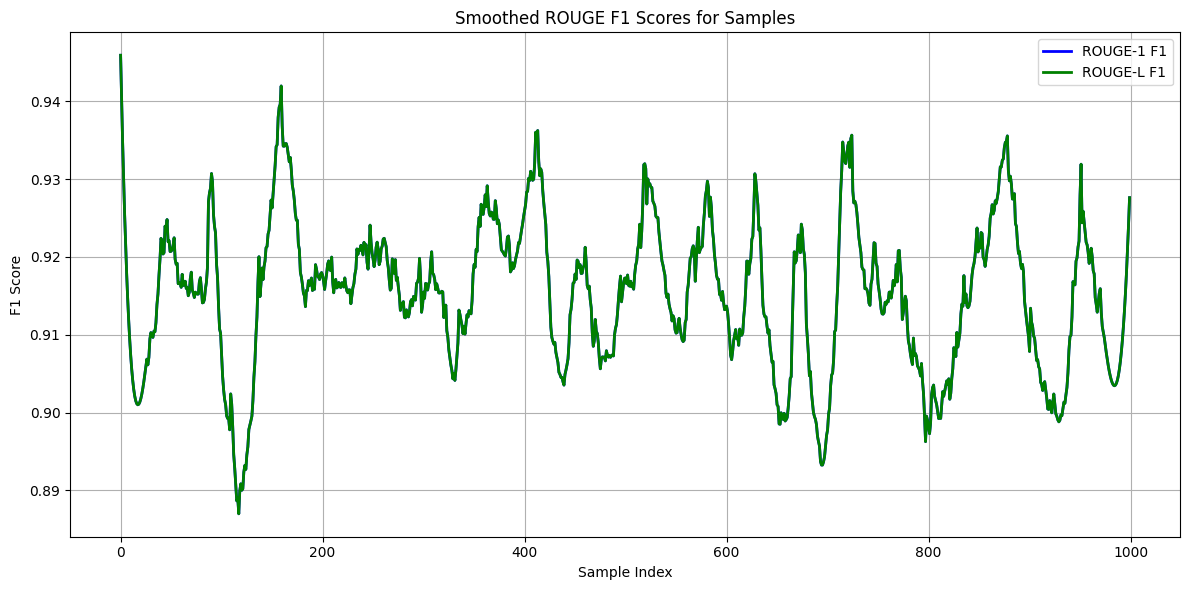

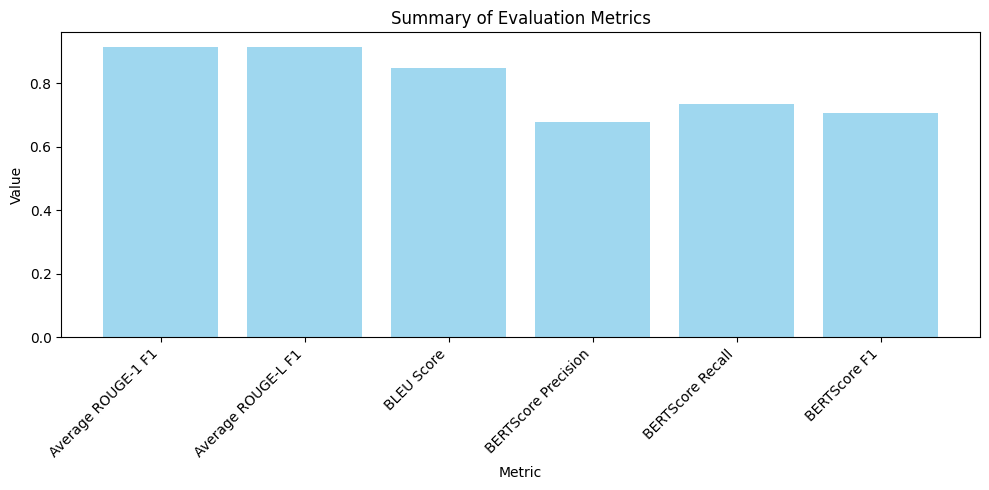

In [91]:

# Define the references and generated_texts for evalation
references = combined_contents_list
generated_texts = combined_answers_list

# Calculate the ROUGE-1 and ROUGE-L scores
rouge_scores = compute_rouge(references, generated_texts)

# Extract ROUGE-1 and ROUGE-L F1 scores
rouge1_f1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rougeL_f1_scores = [score['rougeL'].fmeasure for score in rouge_scores]

# Calculate the BLEU scores
bleu_score_avg = compute_bleu(references, generated_texts)

# Calculate the BERT scores
P, R, F1 = bert_score(generated_texts, references, lang="en", rescale_with_baseline=True)
bert_precision = P.mean().item()
bert_recall = R.mean().item()
bert_f1 = F1.mean().item()

# Create a summary table for overall metrics
summary_table = pd.DataFrame({
    "Metric": ["Average ROUGE-1 F1", "Average ROUGE-L F1", "BLEU Score", "BERTScore Precision", "BERTScore Recall", "BERTScore F1"],
    "Value": [
        np.mean(rouge1_f1_scores),
        np.mean(rougeL_f1_scores),
        bleu_score_avg,
        bert_precision,
        bert_recall,
        bert_f1
    ]
})



# Display the summary table
print("\nSummary of Evaluation Metrics:")
print(summary_table.to_string(index=False))
print("-"*100)

# Apply Savitzky-Golay filter to smooth the lines
smoothed_rouge1_f1_scores = savgol_filter(rouge1_f1_scores, window_length=51, polyorder=3)
smoothed_rougeL_f1_scores = savgol_filter(rougeL_f1_scores, window_length=51, polyorder=3)

# Plot the smoothed ROUGE F1 scores as continuous lines
plt.figure(figsize=(12, 6))
plt.plot(range(len(smoothed_rouge1_f1_scores)), smoothed_rouge1_f1_scores, color='blue', label='ROUGE-1 F1', linestyle='-', linewidth=2)
plt.plot(range(len(smoothed_rougeL_f1_scores)), smoothed_rougeL_f1_scores, color='green', label='ROUGE-L F1', linestyle='-', linewidth=2)

plt.xlabel("Sample Index")
plt.ylabel("F1 Score")
plt.title("Smoothed ROUGE F1 Scores for Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize summary metrics in a bar chart
plt.figure(figsize=(10, 5))
plt.bar(summary_table["Metric"], summary_table["Value"], color="skyblue", alpha=0.8)
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Summary of Evaluation Metrics")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### **RUN THE FOLLOWING CELLS ONLY TO GENERATE THE QUESTIONS**

In [ ]:
from transformers import pipeline
from typing import List, Dict
import os

def generate_questions_with_model(model_pipeline, context, num_questions=3):
    """
    Generates multiple questions from context using the specified model pipeline.
    
    Parameters:
        model_pipeline: Hugging Face model pipeline.
        context (str): The text context from which to generate questions.
        num_questions (int): Number of questions to generate.

    Returns:
        List[str]: A list of generated questions.
    """
    prompt = f"Generate {num_questions} questions based on the following context: {context}"
    try:
        # Use sampling or beam search to generate multiple responses
        responses = model_pipeline(
            prompt, 
            max_new_tokens=100, 
            num_return_sequences=num_questions, 
            do_sample=True,  # Enable sampling
            top_k=50,        # Top-k sampling (optional, enhances diversity)
            temperature=0.7  # Controls randomness; lower values = less random
        )
        return [response['generated_text'] for response in responses]
    except Exception as e:
        print(f"Error generating questions with model: {e}")
        return []

# Function to generate questions using a single LLM and save results
def generate_questions_with_single_llm(docs, dir_output, model_pipeline, model_name, num_questions=3):
    """
    Generates questions using a single LLM and saves them to a JSON file.
    
    Parameters:
        docs (List[Dict]): List of documents to process.
        base_output_file (str): Base path for the output JSON file without extension.
        model_pipeline: Hugging Face model pipeline for generating questions.
        model_name (str): Name of the model for identification in the output.
        num_questions (int): Number of questions to generate per document.
    """
    # Ensure the output directory exists
    os.makedirs(dir_output, exist_ok=True)
    
    results = []
    for doc in docs:
        page_title = doc.metadata['title']
        relevant_context = doc.page_content  # Assuming `page_content` holds the context text

        # Generate multiple questions
        generated_questions = generate_questions_with_model(model_pipeline, relevant_context, num_questions)

        results.append({
            "page_title": page_title,
            "questions": generated_questions
        })

    # Append model name to the output file name
    output_file = f"{dir_output}/{model_name}.json"

    # Save the results to the output JSON file
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)


#### Using `google/flan-t5-base` only

In [ ]:
# Load Hugging Face pipeline
# Replace "google/flan-t5-base" with any model you want to use
flan_t5_generator = pipeline("text2text-generation", model="google/flan-t5-base", device=device)

# Generate questions
generate_questions_with_single_llm(
    docs=chunked_docs,
    dir_output="llm_questions",
    model_pipeline=flan_t5_generator,
    model_name="flan-t5-base",
    num_questions=3  
)

#### Using `EleutherAI/gpt-neox-20b` only

In [ ]:
# Load Hugging Face pipeline
# Replace "google/flan-t5-base" with any model you want to use
gpt_neox_generator = pipeline("text-generation", model="EleutherAI/gpt-neox-20b", device=device)

# Generate questions
generate_questions_with_single_llm(
    docs=chunked_docs,
    dir_output="llm_questions",
    model_pipeline=gpt_neox_generator,
    model_name="EleutherAI/gpt-neox-20b",
    num_questions=3  
)


#### Using `facebook/bart-large` only

In [ ]:
# Load Hugging Face pipeline
bart_generator = pipeline("text2text-generation", model="facebook/bart-large", device=device)

# Generate questions
generate_questions_with_single_llm(
    docs=chunked_docs,
    dir_output="llm_questions",
    model_pipeline=bart_generator,
    model_name="facebook/bart-large",
    num_questions=3  
)
